## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

## Prepare data for model training

In [2]:
with open("../input/he-pgd-turkey-ham/MathCoThon_Ready_Sandwich.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

0

In [3]:
cat_cols = [
    "Genes in mother's side",
    'Inherited from father',
    'Maternal gene',
    'Paternal gene',
    'Status',
    'Respiratory Rate (breaths/min)',
    'Heart Rate (rates/min',
    'Follow-up',
    'Gender',
    'Birth asphyxia',
    'Autopsy shows birth defect (if applicable)',
    'Place of birth',
    'Folic acid details (peri-conceptional)',
    'H/O serious maternal illness',
    'H/O radiation exposure (x-ray)',
    'H/O substance abuse',
    'Assisted conception IVF/ART',
    'History of anomalies in previous pregnancies',
    'Birth defects',
    'Blood test result',
    'Parental consent',
    'Test 1','Test 2','Test 3','Test 4','Test 5',
    'Institute Name',
    'Institute Addr',
    'Institute State',
    'Institute Zipcode',
    "No. of previous abortion",
    'Symptom 1','Symptom 2','Symptom 3','Symptom 4','Symptom 5'
]

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)
cat_cols_indices = [train_df.columns.get_loc(col) for col in cat_cols]
print(cat_cols_indices)

[1, 2, 3, 4, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 17, 12, 13, 14, 15, 16, 8, 41, 42, 43, 29, 33, 34, 35, 36, 37]


In [4]:
temp_df = train_df.groupby(['target']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['target', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.15502555366269166,
 1: 0.019431988041853514,
 2: 0.022916142029715435,
 3: 0.6842105263157895,
 4: 1.0,
 5: 0.05505142165759225,
 6: 0.02893481717011128,
 7: 0.07410423452768729,
 8: 0.03560250391236306}

In [5]:
Xtrain = train_df.loc[:, ~train_df.columns.isin(['target'])].copy()
Ytrain = train_df['target'].copy()
Xtest = test_df.copy()

print(f"Xtrain: {Xtrain.shape} \nYtrain: {Ytrain.shape} \nXtest: {Xtest.shape}")

del train_df
del test_df
gc.collect()

Xtrain: (18047, 991) 
Ytrain: (18047,) 
Xtest: (9465, 991)


20

## Build and validate the model

In [6]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp = 0
counter = 0
oof_score = 0
y_pred_meta_lgb = np.zeros((Xtrain.shape[0], 9))
y_pred_final_lgb = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = LGBMClassifier(
            boosting_type='gbdt', 
            num_leaves=175, 
            max_depth=8, 
            learning_rate=0.012, 
            n_estimators=5000,
            objective='multiclass', 
            class_weight=class_weight,
            min_child_samples=1, 
            subsample=0.75, 
            subsample_freq=10, 
            colsample_bytree=0.725, 
            reg_lambda=0.00489,
            random_state=(seed+idx)
        )
        
        model.fit(train_x, train_y, eval_metric='multi_logloss',
                  eval_set=[(train_x, train_y),(val_x, val_y)],
                  early_stopping_rounds=200, verbose=200,
                  categorical_feature=cat_cols_indices)

        y_pred = model.predict_proba(val_x, num_iteration=model.best_iteration_)
        y_pred_meta_lgb[val] += y_pred
        y_pred_final_lgb += model.predict_proba(Xtest, num_iteration=model.best_iteration_)
        
        y_pred = np.array([np.argmax(y_pred, axis=1)]).T
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        fet_imp += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb = y_pred_meta_lgb / float(len(SEEDS))
y_pred_final_lgb = y_pred_final_lgb / float(counter)
fet_imp = fet_imp / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.746196	valid_1's multi_logloss: 1.52364
[400]	training's multi_logloss: 0.450655	valid_1's multi_logloss: 1.4288
[600]	training's multi_logloss: 0.300487	valid_1's multi_logloss: 1.40694
[800]	training's multi_logloss: 0.209663	valid_1's multi_logloss: 1.41365
Early stopping, best iteration is:
[617]	training's multi_logloss: 0.290205	valid_1's multi_logloss: 1.40637
Seed-2020 | Fold-0 | OOF Score: 30.089790520682534
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.757003	valid_1's multi_logloss: 1.53494
[400]	training's multi_logloss: 0.449748	valid_1's multi_logloss: 1.44916
[600]	training's multi_logloss: 0.300413	valid_1's multi_logloss: 1.43599
[800]	training's multi_logloss: 0.211148	valid_1's multi_logloss: 1.4426
Early stopping, best iteration is:
[669]	training's multi_logloss: 0.263421	valid_1's multi_logloss: 1.4348
Seed-2020 | Fold-1

In [7]:
np.savez_compressed('./LGB_Meta_Features.npz',
                    y_pred_meta_lgb=y_pred_meta_lgb,
                    oof_score=oof_score,
                    y_pred_final_lgb=y_pred_final_lgb)

## Create submission file

In [8]:
test_df = pd.read_csv("../input/predict-generic-disorder/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['Patient Id'] = test_df['Patient Id']
submit_df['target'] = np.array([np.argmax(y_pred_final_lgb, axis=1)]).T

submit_df['target'] = submit_df['target'].map({
    0: "Mitochondrial genetic inheritance disorders//Leber's hereditary optic neuropathy",
    1: 'Mitochondrial genetic inheritance disorders//Leigh syndrome',
    2: 'Mitochondrial genetic inheritance disorders//Mitochondrial myopathy',
    3: "Multifactorial genetic inheritance disorders//Alzheimer's",
    4: 'Multifactorial genetic inheritance disorders//Cancer',
    5: 'Multifactorial genetic inheritance disorders//Diabetes',
    6: 'Single-gene inheritance diseases//Cystic fibrosis',
    7: 'Single-gene inheritance diseases//Hemochromatosis',
    8: 'Single-gene inheritance diseases//Tay-Sachs'
})

submit_df.groupby(['target']).size().reset_index().rename(columns={0:'Count'})

,target,Count
0,Mitochondrial genetic inheritance disorders//L...,292
1,Mitochondrial genetic inheritance disorders//L...,2678
2,Mitochondrial genetic inheritance disorders//M...,1748
3,Multifactorial genetic inheritance disorders//...,24
4,Multifactorial genetic inheritance disorders//...,2
5,Multifactorial genetic inheritance disorders//...,1027
6,Single-gene inheritance diseases//Cystic fibrosis,2503
7,Single-gene inheritance diseases//Hemochromatosis,260
8,Single-gene inheritance diseases//Tay-Sachs,931


In [9]:
submit_df['Genetic Disorder'] = submit_df['target'].apply(lambda x: x.split('//')[0])
submit_df['Disorder Subclass'] = submit_df['target'].apply(lambda x: x.split('//')[1])
submit_df.drop(['target'], axis=1, inplace=True)
submit_df.head()

,Patient Id,Genetic Disorder,Disorder Subclass
0,PID0x4175,Single-gene inheritance diseases,Cystic fibrosis
1,PID0x21f5,Single-gene inheritance diseases,Tay-Sachs
2,PID0x49b8,Single-gene inheritance diseases,Tay-Sachs
3,PID0x2d97,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x58da,Multifactorial genetic inheritance disorders,Diabetes


In [10]:
submit_df.to_csv("./LGB_Submission.csv", index=False)

## Classification Report

In [11]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Paired)
    plt.title('Confusion matrix', fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [12]:
y_pred = np.array([np.argmax(y_pred_meta_lgb, axis=1)]).T
print(classification_report(Ytrain, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.21      0.22       587
           1       0.42      0.38      0.40      4683
           2       0.36      0.36      0.36      3971
           3       0.25      0.13      0.17       133
           4       0.39      0.13      0.20        91
           5       0.33      0.34      0.33      1653
           6       0.41      0.49      0.45      3145
           7       0.33      0.31      0.32      1228
           8       0.32      0.31      0.31      2556

    accuracy                           0.37     18047
   macro avg       0.34      0.30      0.31     18047
weighted avg       0.37      0.37      0.37     18047



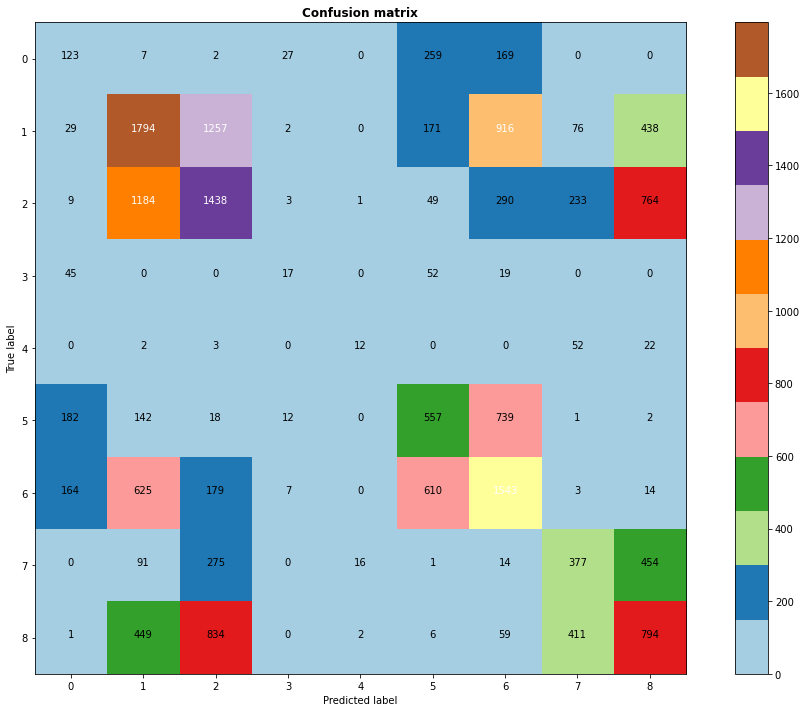

In [13]:
cnf_matrix = confusion_matrix(Ytrain, y_pred, labels=list(range(9)))
np.set_printoptions(precision=2)
plt.figure(figsize=(14,10))
plot_confusion_matrix(cnf_matrix, classes=list(range(9)))

## Features Importance

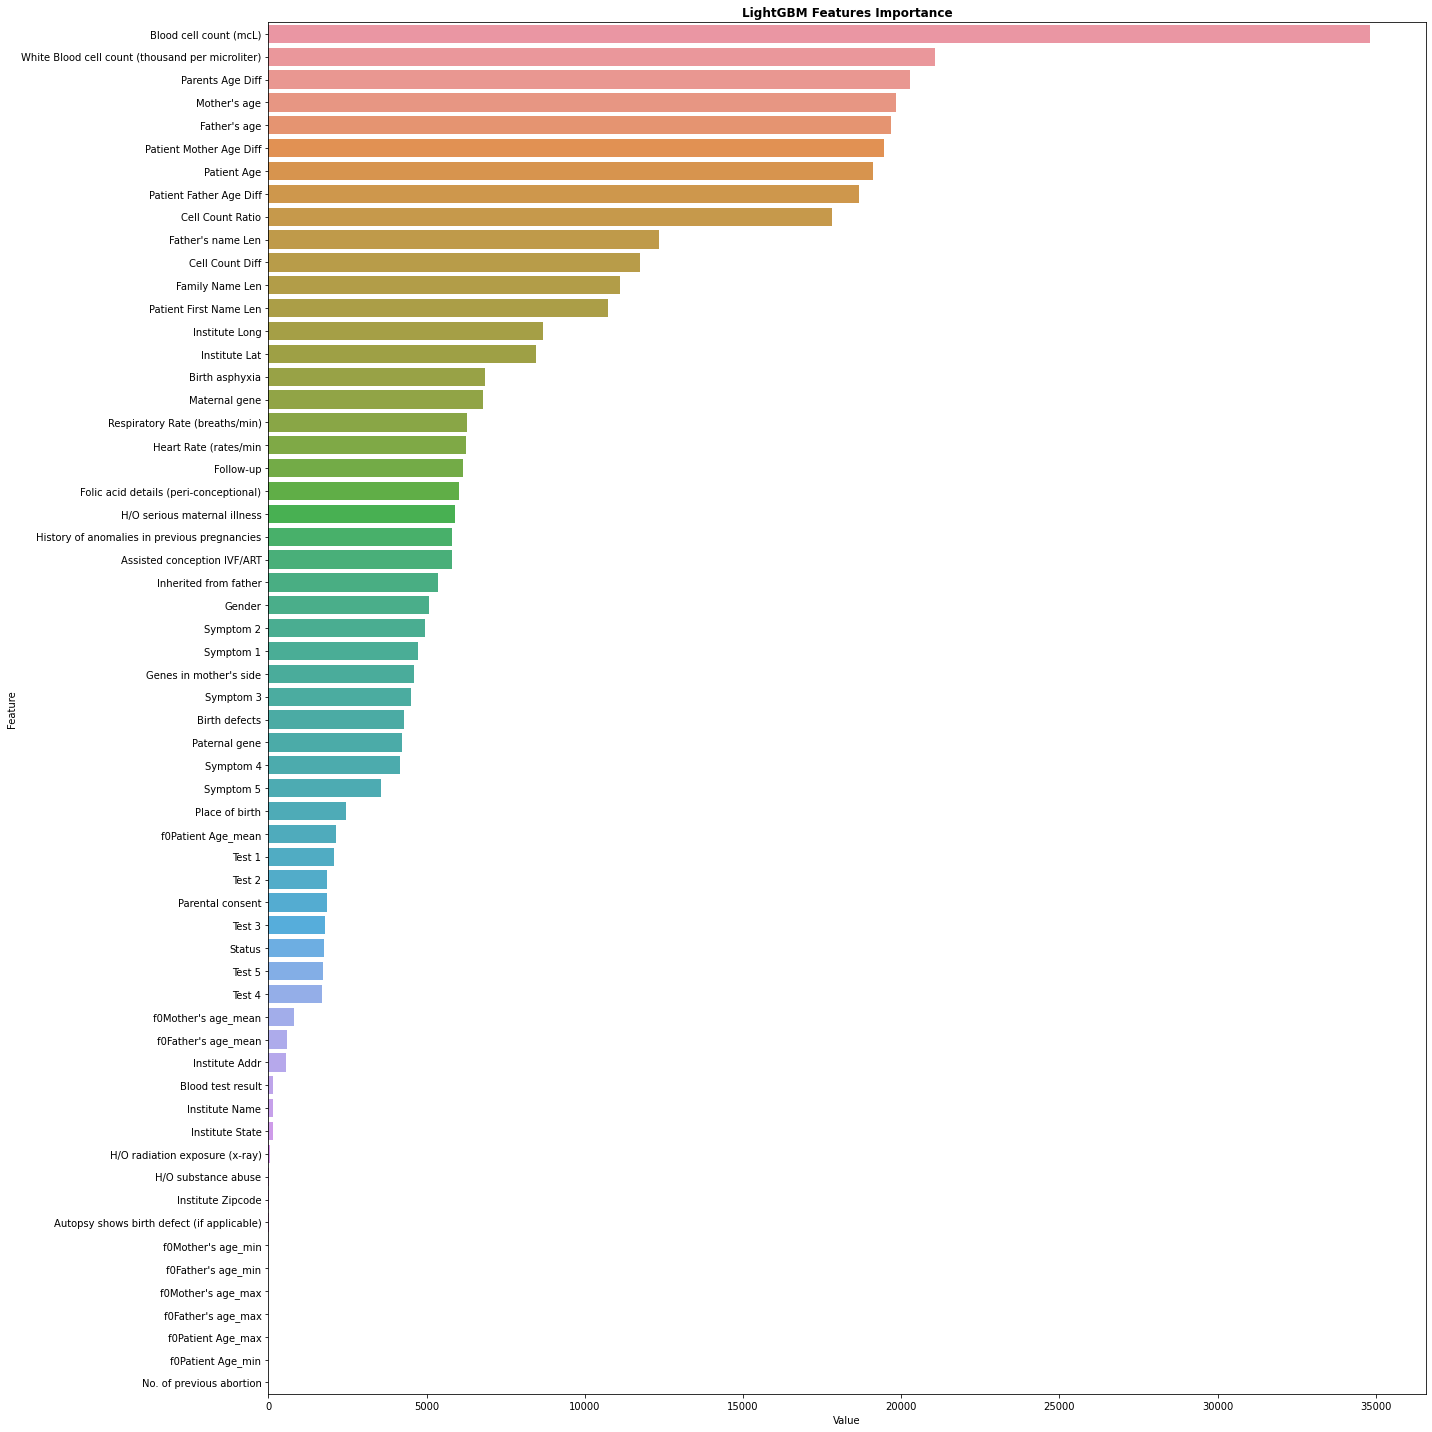

In [14]:
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:60], Xtrain.columns[0:60])), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance', fontweight='bold')
plt.tight_layout()
plt.show()